# Introduction

## Goal

Did you ever wonder what data is sent to the web by your local home network? We do!
With this project we want to analyse our personal network traffic. We first want to understand general information about our network, namely the used protocols, DNS servers, encryption distribution and ethertypes which are mainly used by our clients. Further, we want to analyse the sources and destinations of our requests and which devices sent the most data. Lastly, we want to inspect the collected data by searching for suspicious network traffic. To do so, we want to investigate the traffic of used personal and IoT devices and see how much / which data they share. Moreover, we will take a look at suspicious destinations to see where our data is shared to.

## Hardware Setup

Our hardware setup included three Raspberry Pis, which were setup as a WIFI access point and collected network traffic using `tcpdump`. The Raspberry Pis were then connected to our local routers providing access to the Internet. All of us were using different devices to collect data from. Devices, which were wired via LAN directly to the router could not be tracked. Therefore, the Raspberry Pi could not collect the whole network traffic from our homes, but only a representative part of it.

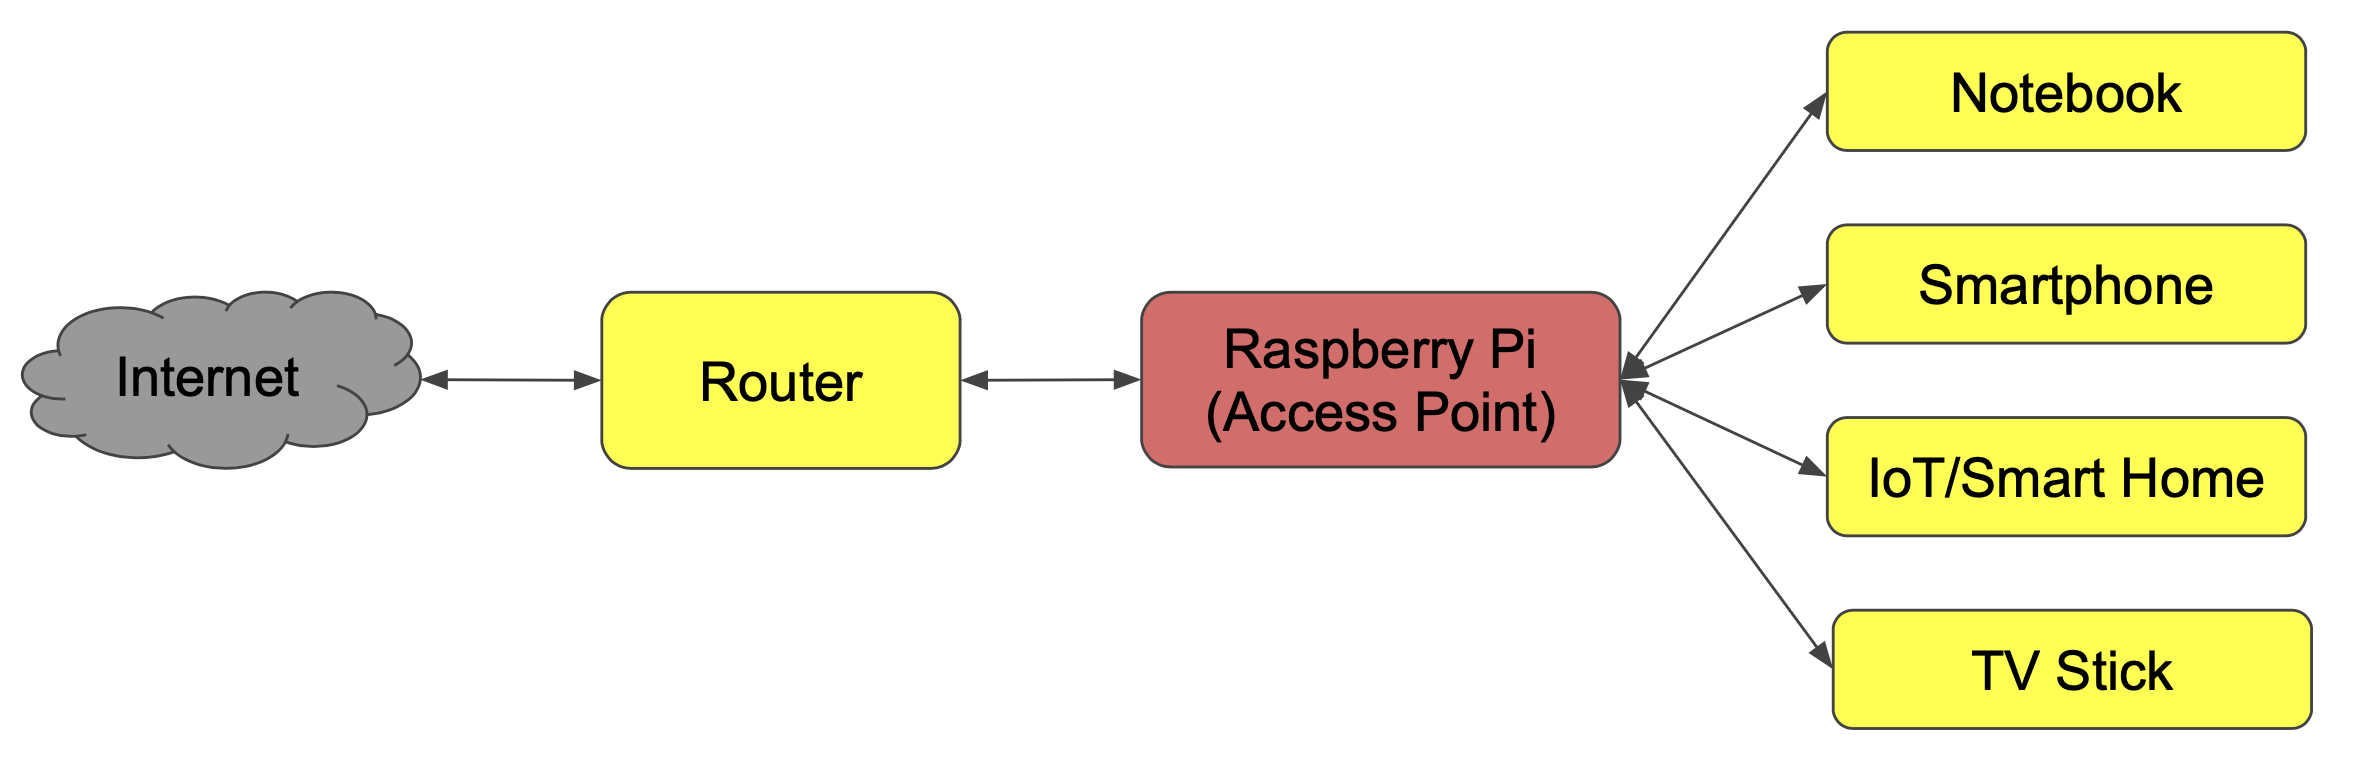

In [39]:
# workaround for displaying images in html/pdf as it didn't work with markdown
from IPython.display import Image
Image(filename="./images/setup-diagram.png")

We orientated on [this guide](https://thepi.io/how-to-use-your-raspberry-pi-as-a-wireless-access-point/) to set up our pis as WIFI access points. After this was successful, we started to collect the data we used the following tcpdump command: `tcpdump -i eth0 -G 86400 -w dumps/%Y-%m-%d_%H-%M_dump.pcap -Z root`. \
This command captures the whole traffic of the eth0 interface, so everything that goes through the LAN port of the Raspberry Pi. We saved the collected dumps into daily chunks which were named after the current date. The root flag was necessary to make sure that the capturing restarted daily.

## Collected Data

We used a wide variety of devices that connected to the access point. The following table shows a summary of the number and types of clients:

|                 | Network Sven                                                 | Network Maxi         | Network Fabi                 |
| --------------- | ------------------------------------------------------------ | -------------------- | ---------------------------- |
| # clients       | 2-10                                                         | 2                    | 6                            |
| Type of clients | Notebook, Smartphone, Vacuum Cleaner, Google Home, TV Stick  | Notebook, Smartphone | IoT, TV Stick, Sonos Speaker |
| Static?         | partially                                                    | no                   | yes                          |

Traffic was recorded for about 5 days each. During this time, we continued with our usual daily Internet browsing behavior. All together we were able to generate a pcap dump of about 54 GB. Wireshark was used to inspect the pcap files and added columns to the standart output which were needed for our analysis, namely the time of the request, ports, and ethertype. We then exported the dump to a .csv file. This resulted in a total of more than 72.5 mio rows (packages). We quickly identified that a huge part of this packages are related to local traffic in our lan. Since we were limited in computational capacity, we decided to ignore local traffic for our analysis and therefore filtered out these packages. This resulted in a total of about 27.8 mio packages.

## Device Mapping

To map the recorded data packages to our devices we noted down which IP address is used by which device. Thus, we can group the traffic per device and analyse the different behavior of the used clients.

The following table shows the mapping of IP addresses to devices:

| IP                                    | Sven's Device | Maxi's Device | Fabi's Devices                         |
| ------------------------------------- | ------------- | ------------- | -------------------------------------- |
| 192.168.178.1                         | Router        |               |                                        |
| 192.168.178.21                        |               | Android Phone |                                        |
| 192.168.178.24                        | Google Home   |               |                                        |
| 192.168.178.26                        | Chromecast    |               |                                        |
| 192.168.178.27                        | Google Home   |               |                                        |
| 192.168.178.29                        | Google Home   |               |                                        |
| 192.168.178.42                        | Google Home   |               |                                        |
| 192.168.178.43                        | SmartTV       |               |                                        |
| 192.168.178.44                        | Android Phone |               |                                        |
| 192.168.178.50                        | iPad          |               |                                        |
| 192.168.178.51                        | MacBook       |               |                                        |
| 192.168.178.58                        | Vacuum Robot  |               |                                        |
| 192.168.178.59                        |               | Notebook      |                                        |
| 192.168.178.60                        | MacBook       |               |                                        |
| 192.168.178.62                        | iPhone        |               |                                        |
| 192.168.178.64                        | SmartTV       |               |                                        |
| 192.168.178.81                        | Android Phone |               |                                        |
| 2003:c1:3712:ac00:e9ad:724d:142a:c5c9 |               | Smartphone    |                                        |
| 2003:c1:3712:ac00:38ee:9c51:e7ee:fe52 |               | Notebook      |                                        |
| 192.168.0.1                           |               |               | Router                                 |
| 192.168.0.2                           |               |               | Wifi Smart Plug                        |
| 192.168.0.8                           |               |               | Amazon Fire TV                         |
| 192.168.0.9                           |               |               | Sonos Wifi Loudspeaker                 |
| 192.168.0.14                          |               |               | iPad                                   |
| 192.168.0.22                          |               |               | ESP32 Microcontroller                  |
| 192.168.0.88                          |               |               | Raspberry Pi used for network sniffing |
| 192.168.0.121                         |               |               | ESP32 with Feinstaubsensor firmware    |
| fe80::271:47ff:fe8d:2e30              |               |               | Amazon Fire TV                         |
| 2003:c1:3720:f300:44f9:8130:108c:d89  | Android Phone |               |                                        |
| 2003:c1:3720:f300:8550:6331:20ec:7cff | Android Phone |               |                                        |
| 2003:c1:3720:f300:35ff:69ab:67a6:7220 | Android Phone |               |                                        |
| fe80::920c:c8ff:fed8:2441             | Chromecast    |               |                                        |


# Setup of the Project

For our analysis we will mainly rely on pandas. Pandas is an open source library for python that allows us to handle large amounts of data with ease. 
The results can be then displayed in nice charts, using matplotlib. Further information on which libraries are needed to run the notebook can be found in the Readme file.The results can be then displayed in nice charts, using matplotlib. 


### Imports



In [ ]:
# Program, run imports
%matplotlib inline
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import time
import seaborn as sns
import requests
sns.set(style="darkgrid")

# used to skip merging, filtering and intesive computation tasks
new_read = False

### Device Mapping 

As previously mentioned, we create a dictionary with the IP addresses of our local devices and their names. This dictionary is later used to assign dataframes to device specific behavior.

In [ ]:
devices_mapping = {
                    '192.168.178.21': 'Android Phone (Maxi)',
                    '192.168.178.24': 'Google Home (Sven)',
                    '192.168.178.26': 'Chromecast (Sven)',
                    '192.168.178.27': 'Google Home (Sven)',
                    '192.168.178.29': 'Google Home (Sven)',
                    '192.168.178.42': 'Google Home (Sven)',
                    '192.168.178.43': 'Smart TV (Sven)',
                    '192.168.178.44': 'Android Phone (Sven)',
                    '192.168.178.50': 'iPad (Sven)',
                    '192.168.178.51': 'MacBook (Sven)',
                    '192.168.178.58': 'Vacuum Robot (Sven)',
                    '192.168.178.59': 'Notebook (Maxi)',
                    '192.168.178.60': 'MacBook (Sven)',
                    '192.168.178.62': 'iPhone (Sven)',
                    '192.168.178.64': 'Smart TV (Sven)',
                    '192.168.178.81': 'Android Phone (Sven)',
                    '192.168.0.2':    "Wifi Smart Plug (Fabi)",
                    '192.168.0.8':    "Amazon Fire TV (Fabi)",
                    '192.168.0.9':    "Sonos Wifi Loudspeaker (Fabi)",
                    '192.168.0.14':   "iPad (Fabi)",
                    '192.168.0.22':   "ESP32 Microcontroller (Fabi)",
                    '192.168.0.88':   "Raspberry Pi used for network sniffing (Fabi)",
                    '192.168.0.121':  "ESP32 with Feinstaubsensor firmware (Fabi)",
                    '2003:c1:3712:ac00:e9ad:724d:142a:c5c9': 'Android Phone (Maxi)',
                    '2003:c1:3712:ac00:38ee:9c51:e7ee:fe52': 'Notebook (Maxi)',
                    'fe80::271:47ff:fe8d:2e30': "Amazon Fire TV (Fabi)",
                    '2003:c1:3720:f300:44f9:8130:108c:d89':  "Android Phone (Sven)",
                    '2003:c1:3720:f300:8550:6331:20ec:7cff':  "Android Phone (Sven)",
                    '2003:c1:3720:f300:35ff:69ab:67a6:7220':  "Android Phone (Sven)",
                    'fe80::920c:c8ff:fed8:2441':  "Chromecast (Sven)",
}
devices_labels = list(set(devices_mapping.values()))

### Create Pandas Dataframe

As mentioned before, we used three different networks to collect our data from. The data were saved in separate .csv-files. To start our analysis, we read all the .csv-files with pandas and concatenate them together in a single large pandas dataframe. The dataframe contains now everything we've captured from our Raspberry Pis.

In [ ]:
if new_read:
    print('Concatenate csv files...')
    df_1 = pd.read_csv("dumps/allPorts_fabian.csv", encoding = "latin")
    df_2 = pd.read_csv("dumps/allPorts_maxi_v3.csv", encoding = "latin")
    df_3 = pd.read_csv("dumps/advanced-dumps-sven.csv", encoding = "latin")
    df = pd.concat([df_1, df_2, df_3])
    print('Concatenate operation completed')
    # TODO check if next line works:
    print('Rows: ', df.shape) 

### Filter Local Traffic
For our analysis we are intersted in all network traffic that is coming from / going to the Internet. Since the traffic captured with `tcpdump` includes also local data traffic, some preporcessing of the data has to be done. 

First, we filter out all data frames whose origin and destination is in the local network. We achieve this by doing several string matches. DNS requests, are usually forwarded by the router to the Internet. Therefore, we exclude DNS from our local network filter. \
Additionally, we captured a lot of broadcast and multicast data. This data frames usually have a specific protocols, which make it easy to filter out for us.\
Finally, we sort our data by timeframe. This is important if we want to track a device behavior over time.

In [ ]:
if new_read:
    # start timer
    time_filter_start = time.time()
    print('Compute intensive task filter started...')

    # filter for local IPv4 network. DNS is not filtered.
    filtered = df.loc[~df['Source'].str.startswith("192.168", na=False) & df['Destination'].str.startswith("192.168", na=False) |
                    df['Source'].str.startswith("192.168", na=False) & ~df['Destination'].str.startswith("192.168", na=False) |
                    df['Protocol'].isin(['DNS'])]
    # filter for local IPv6 network. DNS is not filtered.
    filtered = filtered.loc[filtered['Protocol'].isin(['DNS']) |
                    ~(
                        (filtered['Source'].str.startswith("fd00:", na=False) | filtered['Source'].str.startswith("fe80:", na=False)) &
                        (filtered['Destination'].str.startswith("fd00:", na=False) | filtered['Destination'].str.startswith("fe80:", na=False))
                    )]
    # filter for local multicast and broadcast
    filtered = filtered.loc[~filtered['Protocol'].isin(['DHCP', 'ARP', 'MDNS', 'LLDP', 'SSDP', 'IGMP', 'IGMPv2', 'IGMPv3', 'ICMP', 'ICMPv4', 'ICMPv6', 'ieee1905', 'LLMNR'])]
    filtered = filtered.loc[~filtered['Destination'].isin(['255.255.255.255'])]
    df = filtered 
    
    # sort array by timestamp
    df = df.sort_values(by=['Time'])
    # helper function for time tracking
    time_filter_duration = time.time() - time_filter_start
    print('Task filter completed in ', time_filter_duration, ' seconds')

### Add Column `Device Name`
To improve the overall overview of our Dataframes, we add a `Device Name` coloumn. If an IP address from our previously defined device mapping occurs in the  *Source* or *Destination* field, we add the device to the `Device Name` coloumn. Therefore, we can now see which device is interacting in each dataframe when we decide to print them out.

In [ ]:
if new_read:
    new_read = True # save df later
    time_device_name_calc_start = time.time()
    print('Compute Device Name column...')
    #df_devices = pd.DataFrame({'Source': devices_mapping.keys(), 'Device Name': devices_mapping.values()})
    # df = df.merge(df_devices, on='Source', how='left')
    # Apply Device Name to incoming and outgoing packets
    df.loc[df['Source'].isin(devices_mapping.keys()), 'Device Name'] = df.loc[df['Source'].isin(devices_mapping.keys())].Source.apply(lambda x : devices_mapping[x])
    df.loc[df['Destination'].isin(devices_mapping.keys()), 'Device Name'] = df.loc[df['Destination'].isin(devices_mapping.keys())].Destination.apply(lambda x : devices_mapping[x])
    time_device_name_calc_duration = time.time() - time_device_name_calc_start
    print('Compute Device Name column completed in ', time_device_name_calc_duration, ' in seconds')
    print(df.head(10))

### Add Column `index-time`

In the next step we group our data in 15 minute intervals. Doing so, we can get a better insight in which time period a single device was active and sending data. 

Therefore, we convert the utcTime we got from our tcpdump data to utcTimestamps. These timestamps are then grouped together in our 15 minutes intervals. The corresponding `index` number is then saved in the column `index-time`.

This task is mainly done at this point due to the computational overhead. By adding it as a column, we can cache the values and to not have to recompute them with every run.

In [ ]:
# converts utc time to timestamp 
def utcEntryToTimestamp(entry):
    row_entry = entry.split(".")[0]
    TIME_FORMAT='%Y-%m-%d %H:%M:%S'
    ts = int(datetime.strptime(row_entry, TIME_FORMAT).timestamp())
    return ts

if new_read:
     # start timer
    time_utc_calc_start = time.time()
    print('Computing index-time column...')

    # 15 time interval 
    min_15_duration_internal = 60 * 15
    df['index-time'] = df['Time'].apply(lambda x: utcEntryToTimestamp(x)) # .apply(lambda x: x)) # map to 15 min window
    first_entry_offset_internal = df.iloc[0].at['index-time'] // min_15_duration_internal
    df['index-time'] = (df['index-time'] // min_15_duration_internal) - first_entry_offset_internal

    # print timer
    time_utc_calc_duration = time.time() - time_utc_calc_start
    print('index-time column task completed in ', time_utc_calc_duration, ' seconds')
    


## Save DF to CSV / Load DF from CSV

We save the data frame (df) to a file to cache the filtered data and additionally stored information. This way we don't have to recompute the upper calculations each time but can rather read the cached data frame.

In [ ]:
if new_read:
    df.to_csv('df.csv')
else:
    df = pd.read_csv('df.csv')

print(df)
print(len(df))

# Analysis
Now that the preprocessing is done, we can finally start with our network analysis.
These includes 
- the kind of protocols that are used to send and receive traffic
- source and destination of all packets
- dns requests 
- overall encryption of the traffic
- The use of IPv4 vs IPv6
- Device specific data, such as acitivity periods and specific traffic


We hope that this analysis will help us to find weird uns suspicious traffic on our networks, that we can then investigate further.

## Protocols
Let's start with the protocols! Several protocols exist for sending data trough the web nowadays. Based on their purpose, these can be assigned to the Application, Transport and Internet layer of the famous [OSI Model](https://en.wikipedia.org/wiki/OSI_model). \
Some, but not all are listed here for a better overview:
- Application layer
  - DNS
  - SSH
  - HTTP
  - HTTPS
  - ...
- Transport Layer
  - TCP
  - UDP
  - QUICK
  - ..
- Internet Layer
  - IP (IPv4, IPv6)
  - ICMP
  - ...   

Overall, around 40 different protocols are used by our devices to communicate with the Internet. 
Some of these protocols, such as HTTP, UDP and TCP are quite old. Others, such as the QUICK protocol, were only introduced in the recent years. 



In [ ]:
print("Total number of different protocols that we used: {}\n".format(len(df['Protocol'].unique())))

### Protocol Distribution Among Frames

To get a better overview about the distribution of all protocols among our devices, we decided create a ranking and plot the data in a pie diagram. \
We see that the mayority of our captured frames use **TCP** as underlying protocol. This is not surprising, since TCP is the most used transport protocol and is almost used for every traffic on the web. All other protocols in the application layer do mainly base on TCP, with a few exceptions such as DNS.\
Surprisingly, we also see **QUICK** in our top 5. QUICK, which was recently standardized in May 2021, seems to be heavily pushed on the market by its creator Google. As can be seen from our device list, Google devices claim a large share out of all devices. This might be the reason for its popularity among our captured frames.

In [ ]:
# rank by most used protocols
df_ranked_protocols = df.groupby('Protocol').size()
print(df_ranked_protocols.nlargest(15))


# plot pie diagram
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Protocol Distribution by Amount of Packets')
ax.pie(df_ranked_protocols, labels=df_ranked_protocols.keys(), autopct='%1.1f%%')
fig.show()

### Amount of Data Traffic per Protocol
We also have a look in the amount of data traffic that is sent by each protocol. It seems that this heavily correlates with the protocol distribution among our captured frames. 

In [ ]:
df_data_per_protocol = df.groupby('Protocol')['Length'].sum()
print(df_data_per_protocol.nlargest(15))

fig, ax = plt.subplots(figsize=(10,10))
plt.title('Protocol Distribution by Data Traffic')
ax.pie(df_data_per_protocol, labels=df_data_per_protocol.keys(), autopct='%1.1f%%',)
fig.show()

### Mean Data Length per Protocol Type
In order to investigate which kind if protocol holds the most data per frame, we decided to compute the mean. \
It can be seen that especially SSL and SSH have the greatest amount of data per frame. \
Surprisingly, we also found various industrial protocols, such as H1, PKIX-CRL and HART_IP in this ranking. These protocols are especially designed for sending large data packets. We are not very sure what programs on Maxi's laptop and phone are responsible for this and will investigate this further in a later section of this write-up.

In [ ]:
df_mean_protocol_packet_length = df.groupby('Protocol')['Length'].mean()
print(df_mean_protocol_packet_length.nlargest(15))
#print (df.loc[df['Protocol'].str.contains("HART_IP")])

# plot
fig, ax = plt.subplots(figsize=(10,10))
ax.tick_params(axis='x', which='major', labelsize=12)
ax.tick_params(axis='x', which='minor', labelsize=12)
plt.xlabel('Protocol')
plt.ylabel('Data [Byte]')
plt.title('Mean Data Length per Protocol Type')
ax.bar(df_mean_protocol_packet_length.keys(), df_mean_protocol_packet_length, align='center',)
plt.xticks(rotation=60, ha="right")
fig.show()

## Source and Destination Analysis
Our devices are contacting lots of servers on the Internet. We would like to know which servers are sending and receiving the most data frames. For this, we first group our data by source/destination. Then, we filter all local sources and destinations in our home networks. Finally, we print out a ranking of this data.

In [ ]:
# Data Sources
df_ranked_sources = df.loc[~df['Source'].str.startswith("192.168") & ~df['EtherType'].isin(['IPv6'])] \
    .groupby('Source').size()

print('Sources of Data')
print(df_ranked_sources.nlargest(15))

In [ ]:
# Destinations 
df_ranked_destinations = df.loc[~df['Destination'].str.startswith("192.168") & ~df['EtherType'].isin(['IPv6'])] \
    .groupby('Destination').size()
print('Destination of Data')
print(df_ranked_destinations.nlargest(15))

### ISPs and Location

The previous lists does not reveal anything about the host and location behind the IP. Therefore, we decided to use an external [API provider](https://tools.keycdn.com/geo) to reveal more data for us. The external API provider returns us a json response, were we parse the location and ISP from.

Most of the source and destinations servers in our data belong to cloud providers, content delivery networks (Fastly) or video streaming services (Twitch).

However, we also found some anomalies. Among our most contacted servers is 'SWM Services GmbH', a local Munich infrastructure cooperation. We have to investigate this further in an upcoming section of this writeup. Also, there is the 'Datacamp limited'. A quick Google search reveals that this seams to be a fraudulent isp which is used for various viruses. We will also investigate further into this in a future section.

In [ ]:
# get data about source servers

rows = []
for address, count in df_ranked_sources.nlargest(25).iteritems():
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(address)
    json_response = requests.get(url, headers=headers).json()
    # print(json_response)
    geo = json_response['data']['geo']
    rows.append([geo['ip'], geo['country_code'], geo['longitude'], geo['latitude'], geo['isp']])
    
# as dataframe
df_coord = pd.DataFrame(rows, columns=["ip", "country", "lng", "lat", "isp"])
print(df_coord)

# plot on worldmap
g_world = gpd.GeoDataFrame(df_coord, geometry=gpd.points_from_xy(df_coord.lng, df_coord.lat))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
g_world.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()



In [ ]:
# get data about destination servers
rows = []
for address, count in df_ranked_destinations.nlargest(25).iteritems(): 
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(address)
    json_response = requests.get(url, headers=headers).json()
    #print(json_response)
    geo = json_response['data']['geo']
    rows.append([geo['ip'], geo['country_code'], geo['longitude'], geo['latitude'], geo['isp']])
    
# as dataframe
df_coord = pd.DataFrame(rows, columns=["ip", "country", "lng", "lat", "isp"])
print(df_coord)

# plot on worldmap
g_world = gpd.GeoDataFrame(df_coord, geometry=gpd.points_from_xy(df_coord.lng, df_coord.lat))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
g_world.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()

## Encryption

Next, we want to investigate the encryption of our data. To compute the percentage of encrypted traffic, we base our analysis solely on the used protocols. The reason behind this is that we are not saving the data content of each frame in our .csv-file. 

To distinguish between packages with encrypt content and packages with non-encrypt content we will only look at the following application layer protocols and divide them between non-encrypt and encrypted:
- Encrypted:
  - DTLSv1.2
  - ISAKMP
  - RTCP
  - SSH
  - SSL
  - TLS
  - WireGuard

- Non-Encrypted:
  - DNS
  - HTTP
  - MP4
  - NTP
  - OCSP
  - SMTP
  
- Uncategorized:
  - CLASSIC-STUN
  - HART_IP
  - HCrt
  - IMAP
  - STUN
  - XMPP

Based on this categorization we filter our dataframe. First, we remove all transportation layer protocols. Then, we create three dataframes, one for each category. This gives us an distribution that we can then plot using matplotlib.

In [ ]:
filter_protocols = ['ESP', 'GQUIC', 'H1', 'LWAPP', 'MPTCP', 'QUIC', 'TCP', 'THRIFT', 'TURN CHANNEL', 'UDP', 'UDPENCAP']
encrypted_application_protocols = ['DTLSv1.2', 'ISAKMP', 'RTCP', 'SSHv2', 'SSH', 'SSL', 'SSLv2', 'SSLv3', 'TLSv1', 'TLSv1.2', 'TLSv1.3', 'WireGuard']
non_encrypted_application_protocols = ['DNS', 'HTTP', 'HTTP/JSON', 'HTTP/JSON/XML', 'HTTP/XML', 'MP4', 'NTP', 'OCSP', 'SMTP']
uncategorized_application_protocols = ['CLASSIC-STUN', 'HART_IP', 'HCrt', 'IMAP', 'STUN', 'XMPP/XML']

only_application_protocols = df.loc[~df['Protocol'].isin(filter_protocols)]
only_encrypted_protocols = only_application_protocols.loc[only_application_protocols['Protocol'].isin(encrypted_application_protocols)]
only_non_encrypted_protocols = only_application_protocols.loc[only_application_protocols['Protocol'].isin(non_encrypted_application_protocols)]
only_uncategorized_protocols = only_application_protocols.loc[only_application_protocols['Protocol'].isin(uncategorized_application_protocols)]

content_length_encrypted = only_encrypted_protocols['Length'].sum()
content_length_unencrypted = only_non_encrypted_protocols['Length'].sum()
content_length_uncategorized = only_uncategorized_protocols['Length'].sum()

labels = 'Encrypted', 'Non-Encrypted', 'Uncategorized'
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Encryption Distribution')
ax.pie([content_length_encrypted, content_length_unencrypted, content_length_uncategorized], explode=(0.1, 0, 0), labels=labels, autopct='%1.1f%%',)
fig.show()

By inspecting the plot it can quickly be seen that the encrypted traffic take up the majority of our captured traffic. Only 1.5% of all packages are unencrypted. These mainly includes DNS requests.

In [ ]:
print(only_non_encrypted_protocols.groupby('Protocol').size().nlargest(5))

## IPv6 vs IPv4

In this section we want to inspect the usage distribution of IPv4 and IPv6. To compare this we used the `EtherType` column which was added with WireShark.

In [ ]:
ether_distribution = df.groupby('EtherType').size()

fig, ax = plt.subplots()
plt.title('EtherType Distribution')
ax.pie(ether_distribution, labels=ether_distribution.keys(), autopct='%1.1f%%',)
fig.show()

Only 0.3% of the overall traffic is using the IPv6 protocol, while most of the traffic is still relying on IPv4. This is very interesting as recent [numbers by Google](https://www.google.com/intl/en/ipv6/statistics.html#tab=per-country-ipv6-adoption) show that the IPv6 traffic in Germany is reaching about 55%.
 

### Which Devices are using IPv6?

To further inspect why the IPv6 usage is so low, let's take a look at which devices are using the new address space and with which protocols it used. 

In [ ]:
ipv6_traffic = df.loc[df['EtherType'].isin(['IPv6'])]

print(ipv6_traffic.groupby(['Source', 'Device Name', 'Protocol']).size())

The first insight we get here is that the IPv6 protocol is solely used with the DNS protocol. Another insight is that mostly Google based devices (Android Phone, Chromecast) and the Windows notebook are using IPv6. Despite having a lot of Apple Devices in the list none of them seam to use the new internet protocol. 

## DNS 

Every device that is connected to the Internet uses DNS to resolve URLs of their desired destination services. This DNS requests are particular interesting, since they can reveal a lot of a devices web browsing behavior or the various servers it is contacting over time.
In order to get this information, we filter our large data dump by the protocol "DNS".

In [ ]:
df_dns = df[df['Protocol'] == 'DNS']
print(df_dns.head(1))

### Used DNS Server

Various DNS resolvers exist on the Internet. We would like to find out which of these are our devices using. 
Some devices can be configured to use a specific DNS Servers, some devices have their preferred DNS resolver hardcoded in their firmware. In many cases the resolve request is just forwarded to the router, who takes care of this. 

By grouping our DNS Destinations and counting the requests, we see which resolvers were primarily used by our devices.

In [ ]:
df_dns_server = df_dns.loc[~df_dns['Info'].str.contains("response")]
print(df_dns_server.groupby(['Destination']).size().nlargest(15))

We see that most of our DNS requests were send to our routers. This includes the destinations starting with *192.168.* or *fd00*. Other devices use well known DNS resolvers, such as Google's *8.8.8.8* or *2001:4860:4860::8888*. 

However, we also found three unknown DNS resolvers (*217.68.162.126*, *17.68.162.126* and *2a02:2457:10c:101::126*). A print out of these requests reveals that the Feinstaubsensor IoT device and the  Sonos loudspeaker are using *217.68.162.126* and *17.68.162.126* resolve their destinations. These to DNS resolvers are provided by the local ISP "PYUR". \
*2001:4860:4860::8888*  seems to be an IPv6 DNS resolver, that is used by our Amazon fire TV to resolve its requests. 

In [ ]:
print(df_dns_server.loc[df_dns_server['Destination'].str.contains("195.234.128.139")].groupby('Device Name').size())
print(df_dns_server.loc[df_dns_server['Destination'].str.contains("217.68.162.126")].groupby('Device Name').size())
print(df_dns_server.loc[df_dns_server['Destination'].str.contains("2a02:2457:10c:101::126")].groupby('Device Name').size())

Another great insight is the information about the URLs, that are actually being resolved. This can also be used to track a devices browsing behavior. We count the requests by URL to get a better overview. \
Many DNS requests are used internally for Fritzbox specific services (Our Router). Others, such as "server.chillibits.com" are contacted regulary by static IoT devices, such as the custom build air quality sensor. \
Especially on personal computers and mobile devices, a browsing behavior from DNS requests can be seen with this analysis. This includes our love for Reddit, as its endpoints can be seen multiple times in this DNS list. 👨🏽‍🚀

In [ ]:
# only look at standart query dns requests
df_dns_requests = df_dns[df_dns['Info'].str.contains('Standard query')]
# exclude responses from count
df_dns_requests = df_dns_requests[~df_dns_requests['Info'].str.contains('response')]
# display URLS
df_dns_urls = df_dns_requests['Info'].apply(lambda x: x.split(' ')[-1]).value_counts()
print('ns-287.awsdns-35.com' in df_dns_urls.keys())
print(df_dns_urls.nlargest(30))

## Data traffic over time
In this section we want to investigate our traffic over a longer time period. Therefore, we created 15 minute intervals and assigned data traffic to those timeframes earlier in the setup of this project.
For easier display and plotting, we created the function `time mapping`. This function maps a timeframe index to a label, which is then used for several diagrams.

In [ ]:
# init constants for following sections
min_15_duration = 60 * 15
first_entry_offset = utcEntryToTimestamp(df.iloc[0].at['Time']) // min_15_duration


def timeMapping(x):
    # apply time difference UTC+1 to labels, only show a label every 6 hours
    time = datetime.utcfromtimestamp((first_entry_offset+x)*min_15_duration + 3600)
    if time.minute == 0 and time.hour == 0:
        return time.strftime("%H:%M\n%d.%m")
    if time.minute == 0 and time.hour % 6 == 0:
        return time.strftime("%H:%M")
    else:
        return ""
# get first and last timestamp
first_entry = df.iloc[0].at['index-time']
last_entry = df.iloc[-1].at['index-time']

print('from ', df.iloc[0].at['Time'], " to ", df.iloc[-1].at['Time'])

x_values_packets = list(range(first_entry, last_entry + 1))
print('Amount of Intervals',len(x_values_packets))

mapping_res = list(map(timeMapping, x_values_packets)) # create a label mapping for each timeframe
# initialize data structures for data traffic over time
count_packets = np.zeros(last_entry - first_entry + 1)
length_packets = np.zeros(last_entry - first_entry + 1)



For each timeframe (15 minute interval), we count how many packets were exchanged and sum up the total length of all packets in MB. \

In [ ]:
# calculate values for data traffic
time_start = time.time()
print('Compute packet count and data traffic over time...')
df_traffic_grouped = df.groupby(['index-time']).Length.sum()
df_packet_grouped = df.groupby(['index-time']).count()

for timeframe, values in df_packet_grouped.iterrows():
    count_packets[timeframe] += values['Length']

for timeframe, values in df_traffic_grouped.iteritems():
    length_packets[timeframe] += values
length_packets = length_packets // 1000000 # convert to MB
time_end = time.time()
print('Computation completed in ', time_end - time_start, ' seconds')

The final results of the computation are then plotted.
The two resulting graphs then visualizes the data traffic over time, which is usually very high. \

It can be easily observed that traffic does not only occur during daytime, but also at night. This is especially the case when investigating our IoT devices. We've also had brief look in several spikes in the diagram. Most of the time these resulted of several hours video streaming.

In [ ]:
# print(count_packets)
# print(length_packets)
fig, ax = plt.subplots(figsize=(40, 5))
plt.xlabel('Time')
plt.ylabel('Packets')
plt.title('Packets per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.plot(x_values_packets, count_packets, color='black')
fig.show()

fig, ax = plt.subplots(figsize=(40,5))
plt.xlabel('Time')
plt.ylabel('Data [MB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.plot(x_values_packets, length_packets, color='black')
fig.show()

## Device Evaluation

Next, we want to compute several statistics about individual devices. For each device, we know how much incoming and outgoing data traffic occurs in each timeframe. The dataframe `df_device_traffic` contains the data amount (in bytes), the column entry is a device name and the row entry is related to the timeframe (in 15 min intervals). Even rows contain data related to incoming traffic and uneven rows are for outgoing traffic. A similar pattern applies to `df_device_packets` which only counts the amount of packets for a device in a certain timeframe and traffic direction (upload or download). 

Furthermore, the dataframes `df_device_ip_dest` and `df_device_ip_source` contain the most popular destination or source ip addresses aggregated by device. This dataframe is sorted in descending order.

Therefore, following code is just used for precalculating data and used in later sections.

In [ ]:
# define data structure for device metadata
df_device_traffic  = pd.DataFrame() # counts incoming and outgoing data
df_device_packets = pd.DataFrame() # counts incoming and outgoing packets

# initialize data structure
for name in devices_labels:
    count_packets_device = np.zeros(2 * (last_entry - first_entry + 1)) # track incoming and outgoing traffic
    length_packets_device = np.zeros(2 * (last_entry - first_entry + 1))
    df_device_packets[name] = count_packets_device
    df_device_traffic[name] = length_packets_device

# Perform aggregation of data
print('Process incoming and outgoing traffic per device...')
# Outgoing traffic: Device sends traffic
df_device_out = df.loc[(df['Source'].isin(devices_mapping.keys()))]
df_device_out_packets = df_device_out.groupby(['Source', 'index-time']).count()
df_device_out_data = df_device_out.groupby(['Source', 'index-time']).Length.sum()
# Incoming traffic: Device receives packet
df_device_in = df.loc[(df['Destination'].isin(devices_mapping.keys()))]
df_device_in_packets = df_device_in.groupby(['Destination', 'index-time']).count()
df_device_in_data = df_device_in.groupby(['Destination', 'index-time']).Length.sum()

# Popular ip address destinations grouped by device
df_device_ip_dest = df.loc[(df['Source'].isin(devices_mapping.keys()))]
df_device_ip_dest = df_device_ip_dest.groupby(['Device Name', 'Destination']).Length.count().sort_values(ascending=False)
# Popular ip address sources grouped by device
df_device_ip_source = df.loc[df['Destination'].isin(devices_mapping.keys())]
df_device_ip_source = df_device_ip_source.groupby(['Device Name', 'Source']).Length.count().sort_values(ascending=False)

# transfer processed data to data structures
# process Outgoing traffic
for (ip, timeframe), values in df_device_out_packets.iterrows():
    # calculate index
    index = 2 * timeframe + 1
    df_device_packets.loc[index, devices_mapping[ip]] += values['Length']
for (ip, timeframe), values in df_device_out_data.iteritems():
    index = 2 * timeframe + 1
    df_device_traffic.loc[index, devices_mapping[ip]] += values

# process Incoming traffic
for (ip, timeframe), values in df_device_in_packets.iterrows():
    # calculate index
    index = 2 * timeframe
    df_device_packets.loc[index, devices_mapping[ip]] += values['Length']
for (ip, timeframe), values in df_device_in_data.iteritems():
    index = 2 * timeframe
    df_device_traffic.loc[index, devices_mapping[ip]] += values


### Device Communication Endpoints 

We want to know with whom exactly each device is communicating. These are ranked with the following code printout. 
#### Outgoing Traffic (Upload) ####
The most traffic comes from the ESP32 device and goes to the MVG endpoint ('188.164.238.26'). 
Maxi's notebook also had many outgoing packets. The most contacted destinations, namly *52.223.201.182*, *52.223.201.100* and *185.42.205.193*, lead us to hosts such as 'video-edge-c68130.fra02.no-abs.hls.ttvnw.net'. These hosts belongs to the livestreaming service Twitch. \
Some Oracle cloud addresses can be traced back to Zoom by looking at responses from dns resolvers, e.g. zoomff130-61-166-170mmr.cloud.zoom.us for 130.61.166.170. Also, we captured outgoing traffic to an CDN from Limelight Networks (*178.79.232.14*), which is used to support the video streaming. \
In the notebook's traffic, there is also university related traffic such as *138.246.224.36* for an university IDP project. The IP address *131.159.0.186* resolves to *rbgse35.in.tum.de* hostname, which is responsible for BBB-traffic. Other university related addresses are *129.187.255.213* and *'141.40.250.3'*, which are used for the university's private cloud (LRZ sync & share). \
Other popular destinations are mostly related to Zoom, Spotify, Amazon and Twitch.

Notably, we found some suspious destinations that are contacted by Sven's Android phone. These includes the IP addresses *89.187.169.39* and *185.59.220.199*. We will have a deeper look into these in an upcoming section.

#### Incoming Traffic (Download) ####
The device with the highest incoming traffic was Maxi's notebook which was used for watching Twitch livestreams (*52.223.201.182* and *52.223.201.100*), communicating with Microsoft (*52.113.63.202*) and communicating with a Zoom service hosted in the Oracle cloud (*130.61.166.170*). 
Sven's notebook also used Zoom, but the contacted server was different (*134.224.101.38*).

Maxi's smartphone often communicated with Reddit, therefore the connection with Fastly's CDN (*199.232.189.140*) is no real surprise. Fabian's SONOS loudspeaker was also often connected to the Fastly CDN, as the speaker streamed content from Spotify (*199.232.138.248*). Sven's Macbook was often involved in Zoom calls (*134.224.101.38*). We observed some traffic from Sven's Chromecast to an Amazon server (*54.182.252.136*), which was related to his Amazon Prime video subscription. 
A little surprising was the favorite source address *52.113.47.239* from Sven's iPhone, it is a Microsoft server and not from Apple. The explanation for this was the Microsoft Teams App. 

In [ ]:
df_device_ip_dest.head(25) # output outgoing traffic


In [ ]:
df_device_ip_source.head(25) # output popular incoming traffic ip addresses

### Traffic by Device ###
By far, the most traffic was produced by Maxi's notebook due to high media consumption in the form of videos and watching livestreams. Furthermore, the device also had a high upload traffic caused by data uploads for this project and sharing preprocessed data to other group members. 

Other devices with much download traffic were smartphones, Macbook, Chromecast and one ESP32 device. Interestingly, although the amount of web requests and web responses is almost equal, the responses causes are much larger amounts of traffic. 


In [ ]:
# for each device, plot a bar that shows the data traffic (incoming and outgoing) and amount of packets
# aggregate data
df_device_in_total = (df_device_traffic.iloc[::2].agg(['sum']) // 1000000).transpose()# even rows, incoming traffic, convert to MB
df_device_out_total = (df_device_traffic.iloc[1::2].agg(['sum']) //1000000).transpose()# odd rows, outgoing traffic, convert to MB

df_device_in_total_num = df_device_in_total['sum'].to_numpy()
df_device_out_total_num = df_device_out_total['sum'].to_numpy()

df_device_in_packets_total = (df_device_packets.iloc[::2].agg(['sum'])).transpose()# even rows, incoming traffic
df_device_out_packets_total = (df_device_packets.iloc[1::2].agg(['sum'])).transpose()# odd rows, outgoing traffic
df_device_in_packets_total_num = df_device_in_packets_total['sum'].to_numpy()
df_device_out_packets_total_num = df_device_out_packets_total['sum'].to_numpy()

# plot data traffic per device
fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Devices')
plt.ylabel('Data [MB]')
plt.title('Data traffic per Device')
plot_x_devices_traffic = np.arange(len(devices_labels))
plt.xticks(plot_x_devices_traffic, devices_labels, rotation=60, ha="right")
ax.bar(plot_x_devices_traffic, df_device_in_total_num, width=0.4, label="Download", color='green')
ax.bar(plot_x_devices_traffic + 0.4, df_device_out_total_num, width=0.4, label="Upload", color='red')
ax.legend()
fig.show()

# plot packets

fig, ax = plt.subplots(figsize=(15,5))
plt.xlabel('Devices')
plt.ylabel('Packets')
plt.title('Packets per Device')
plot_x_devices_traffic = np.arange(len(devices_labels))
plt.xticks(plot_x_devices_traffic, devices_labels, rotation=60, ha="right")
ax.bar(plot_x_devices_traffic, df_device_in_packets_total_num, width=0.4, label="Download", color='green')
ax.bar(plot_x_devices_traffic + 0.4, df_device_out_packets_total_num, width=0.4, label="Upload", color='red')
ax.legend()
fig.show()

### Device Activity ###

The following plot shows at which timeframes packets from or to the device were captured. A single captured packet in a timeframe is sufficient to identify the device as "active". It does not show user activity, but it visualizes when the device was connected to the network and if it was used for data exchange with the web.

For Fabian's measurements, the capture stopped approximately 12 hours earlier than the others and therefore are incomplete for the related devices. Another issue was the connection behavior of some devices, which connected to a neighboring WIFI networks. Therfore, our Raspberry Pi could not capture the traffic in certain timeframes (e.g. applicable to iPads and some smartphones).

Static devices were always online, some devices send data even during standby phases. Examples are the Fire TV stick, ESP32 device with Feinstaubsensor firmware, the SONOS loudspeaker or the ESP32 contacting SWM Services. Even patterns could be found in those IoT devices. The SONOS loudspeaker and the fire TV stick had web activities in short intervals. The WIFI smart plug was also regularly online, but the intervals between web requests were larger than 15 minutes.

Non static devices, such as smartphones and notebooks were only sending data while they were switched on. In the diagrams below, the intervals with an active connection to the Raspberry Pi can be clearly identified. In some cases (e.g. Maxi's smartphone), the device had a permanent connection during the night and still communicated to the Internet although the user was sleeping.

One interesting devices is the vacuum cleaner, which often was active for around 24 hours per session and effectively only worked for a few hours. The Google Home device was also connected for a longer amount of time until it randomly decided to disconnect from the network.

In [ ]:
# plot activity
# activity = 1 packet send/received within a timeframe, 0: no device activity
packets_1 = df_device_packets.iloc[::2].to_numpy()
packets_2 = df_device_packets.iloc[1::2].to_numpy()

combined = np.minimum(np.add(packets_1, packets_2), 1).transpose()
print(combined.shape)
plot_X_activity = np.arange(combined.shape[1])


fig, ax = plt.subplots(nrows=combined.shape[0], ncols=1, figsize=[20, 40])
plt.setp(ax, xticks=x_values_packets, xticklabels=mapping_res,
        yticks=[0, 1],xlabel='Time', ylabel="Activity", )

for index in range(combined.shape[0]):
    if index % 2 == 0:
        ax[index].plot(x_values_packets, combined[index], label=devices_labels[index], color="red")
    else:
        ax[index].plot(x_values_packets, combined[index], label=devices_labels[index], color="blue")
    ax[index].legend()


fig.show()

### Nightly Behavour 

We wanted to know how devices utilized the Internet connection at night without (much) user interaction. Therefore, we decided to only use captured data between midnight and 6am for this section. 
IoT devices are very common in this list due to their always-on principle. This includes the ESP32 devices, which communicates with the SWM endpoint (*188.164.238.26*) or the air pollution sensor, which continuously makes its data available to the public (*85.214.202.106*, *81.169.180.11*, *85.214.67.97*).

There was still some LRZ (University) traffic, namely to *129.187.255.213*, *141.40.250.0/24*, *138.246.224.36* in the night on Maxi's notebook. This was due to a meeting on the following day. Some Reddit traffic on notebook and smartphone was also recorded (*199.232.189.140*). A few exchanges with Google servers from the SONOS loudspeaker (*104.199.65.124*) and the Chromecast (*8.8.8.8*) can also be seen.

In [ ]:
def isNighttime(timeframe):
    timestamp = (first_entry_offset + timeframe) * min_15_duration
    hour = datetime.fromtimestamp(timestamp).hour
    return hour <= 4 or hour >= 23 # apply 1 hour time difference

nighttime_timeframes = []
for x_item in x_values_packets:
    if isNighttime(x_item):
        nighttime_timeframes += [x_item]

df_nighttime_dest = df.loc[(df['index-time'].isin(nighttime_timeframes) & df['Source'].isin(devices_mapping.keys()))] # (df['Protocol'] == "DNS") & 
df_nighttime_device_dest = df_nighttime_dest.groupby(by=['Device Name', 'Destination']).Length.count().sort_values(ascending=False)
df_nighttime_device_dest.head(25)


## Find the Mole

During our network traffic analysis we came along some suspicious outliers. This included
- SWM Services GmbH being in our top contacted server
- An ISP called "Datacamp Limited", which was the top contact of an android phone
- Several industrial protocols that are used to sent large packets of data to the web
- Lots of traffic traffic from a Roborock "Smart Vaccuum Robot"

In this section we will investigate these phenomena closer and try to understand what is happening here in our networks.

### Forgotten Subway Depature Display
We've found our first suspicious case during our source and Destination analysis. Here, we got a server belonging to "SWM Services GmbH". Let's see what is going on here and why it is in our top contacted servers of all our devices. 

First, we need to know which of our devices is contacting this server.

In [ ]:
swm = df.loc[df['Destination'].isin(['188.164.238.26'])] 
print(swm.groupby(['Device Name']).size())

The only device that is contacting SWM is our ESP32 Microcontroller. This Microcontroller is used to display live subway departure times on a small display. Hence, it makes sense that it would regulary contact SWM Services GmbH to get the data from their server.

However, there seems to be something misconfigured with the number of requests. Printing out the timestamps of each sent and received data frame shows us that we have around 25 packets within 10 seconds sent from and to SWM. During our 5 day data capture, this summed up to a total of 1057066 packages of data. 

This device is running 24/7 for several years now. We quite sure now that SWM did not implement a rate limit on their public Api endpoint. Else, this horrendous Api spamming would've not been possible.

In [ ]:
print(swm.Time.head(25))
print("Number of total packages: {}".format(len(swm)))

### Suspicious H1 protocol sends large amount of data

One unknown industrial protocol was the H1 protocol, which was suspicious due to its large average packet size.
We could observe seven incoming packets with H1 traffic during our capturing period, which were in most cases from the LRZ (141.40.250.0/24). Other packets were from the CDN Limelight Networks (178.79.232.14), Google (104.199.65.124) and Amazon (34.249.234.158). 
The purpose of these packets is still unknown to us because it is usually used with Siemens SIMATIC devices (Source: https://wiki.wireshark.org/H1) and there were no such devices in our network.

In [ ]:
df_h1 = (df.loc[df['Protocol']=='H1'])[['Time', 'Source', 'Destination', 'Length', 'Device Name']]
print(df_h1)

### Roborock Vacuum Robot

As Xiaomi (and other chinese manufacturer) with their smart devices are often in the critic to violate privacy we wanted to have a closer look at the traffic the `Roborock S5 Max` smart vacuum cleaner and the companion app sent. We focused on the location the packages are sent to. Roborock is saying that their devices are GDPR compliant and all EU data is stored in a german server center.

In [ ]:
vacuum_traffic = df.loc[df['Device Name'].isin(['Vacuum Robot (Sven)'])].groupby('Destination').size()
# get data about destination servers
rows = []
for address, count in vacuum_traffic.iteritems(): 
    if address.startswith('192.168'):
        continue
    headers = { 'User-Agent': "keycdn-tools:https://www.example.com" }
    url = "https://tools.keycdn.com/geo.json?host={}".format(address)
    json_response = requests.get(url, headers=headers).json()
    geo = json_response['data']['geo']
    rows.append([geo['ip'], geo['country_code'], geo['longitude'], geo['latitude'], geo['isp']])

# as dataframe
df_coord = pd.DataFrame(rows, columns=["ip", "country", "lng", "lat", "isp"])
print(df_coord)

# plot on worldmap
g_world = gpd.GeoDataFrame(df_coord, geometry=gpd.points_from_xy(df_coord.lng, df_coord.lat))

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black')
g_world.plot(ax=base, marker='o', color='red', markersize=5)
plt.show()

To our dissappointment (or luck) the data is sent to the Amazon Server located in Frankfurt and therefore is indeed GDPR compliant. However, we cannot say what happens with the data after beeing processed by the Amazon servers and therefore can not assuare the data privacy. That's why we wanted to have another look using [Mitmproxy](https://mitmproxy.org). With this tool we can even take a look into encrypted packages which are sent and received by the companion app.


#### Mitmproxy analysis

And again the Roborock app and the according API seam to be compliant to all security standards. None of the visible decrypted responses showed a significant privacy problem. The only interesting request that was found was the following GET request https://api-eu.roborock.com/user/homes/712040/rooms and the corresponding response: 

``[{"id":4015991,"name":"Bedroom 2"},{"id":768374,"name":"Office"},{"id":768370,"name":"Bathroom"},{"id":768366,"name":"Bedroom"},{"id":768364,"name":"Floor 2"},{"id":768360,"name":"Living Room"},{"id":768356,"name":"Floor"},{"id":768352,"name":"Kitchen"}]``

However, all of the found endpoints were secured with authorization and couldn't be accessed publicly.

We can conclude that Xiaomi is doing a good job with protecting the users privacy and is indeed GDPR conform.

### Datacamp Limited

When researching the different ISP's which appeared in the previous Source and Destination Analysis the Datacamp Limited seamed scamy. The first source for this was a rating by [Scamalytics](https://scamalytics.com/ip/isp/datacamp-limited) which indicates a "very high fraud risk" for this ISP. Therefore, we put more investigation into this topic.

By reasearching the company behind the ISP we found a CDN network with more suspicious behaviour. According to the [D&B Business Directory](https://www.dnb.com/business-directory/company-profiles.datacamp_limited.914baba433b38b62196ceb3cc013b06f.html) the company has only 2 employees but a yearly revenue of nearly $50 million. By looking into the founder of the company [Zdeněk Cendra](https://translate.google.com/website?tl=de&client=webapp&u=https://cs.m.wikipedia.org/wiki/Zden%25C4%259Bk_Cendra&sl=cs) we found out that he owns at least 5 more companies which are related to data processing and hosting and has a net worth of about 100 million Euro. 

Since all the traffic going to the Datacamp Limited servers is encrypted we sadly couldn't find any more suspicious information about the CDN. 

Still we want to investigate which device is sending all the request to Datacamp. We therefore searched for the top 5 ip addresses in our data frame which are related to the ISP and filtered for them.

In [ ]:
datacamp_traffic = df.loc[df['Destination'].isin(['89.187.169.15', '89.187.169.39', '185.59.220.199', '185.59.220.198', '185.59.220.194', '185.59.220.193'])]
print(datacamp_traffic.groupby('Device Name').size())

We can see that only one device, namely Sven's Android device, is responsible for all the traffic which is going to the suspicious CDN. To see when this request are made we do the over time analysis from the previous chaapter on this filtered data frame.

In [ ]:
datacamp_traffic.groupby('index-time').Length.size()
datacamp_traffic_grouped = datacamp_traffic.groupby(['index-time']).Length.sum()

length_packets = np.zeros(last_entry - first_entry + 1)

for timeframe, values in datacamp_traffic_grouped.iteritems():
    length_packets[timeframe] += values
length_packets = length_packets // 1000 # convert to kB
time_end = time.time()

# print(length_packets)
fig, ax = plt.subplots(figsize=(40,5))
plt.xlabel('Time')
plt.ylabel('Data [kB]')
plt.title('Data traffic per timeframe (15 min interval)')
plt.xticks(x_values_packets, mapping_res)
ax.plot(x_values_packets, length_packets, color='black')
fig.show()

With this information we could limit the services which are sending the requests to Datacamp already. 

Additionally, we used Wiresharks ability to reverse engineer data frames with the related IP address. With this, we could find out that the data consists of links to [Bunny.net](bunny.net), another CDN provider. Another reasearch showed that this CDN provider is ofthen related to Mangas. Through this information we were able to find another link in the Wireshark dump which finally led us to the responsible application. It was MangaMelon, a free Manga Reader application, which is appearantly using Datacamp Limited as their CDN provider. A last research showed that MangaMelon is not available in the Google Play Store anymore, but we could not find any statement about the reason. 

Our suspicion is that the many requests send by this app are not compliant with the Google Play Store policy and that the app is also violating the users data privacy. However we couldn't prove this due to the encrypted data traffic. Our suspect about the high traffic to Datacamp was indeed correct and as a bottom line the MangaMelon app was immediately deleted from our phone. 

# Final Thoughts

A network analysis of a home network reveals a lot of insights, that are happening without or knowledge. It helps to discover suspicious traffic, that else would've been stayed hidden.  We were quite astound to what extend unwanted traffic is in our networks. We are quite happy that we could finally to neutralize our found "moles" in the networks. However, this is only a momentary snapshot. As we have seen with the malicious app on Sven's Android phone, it often only takes one incorrect installation to catch malware.

It was also very fascinating what daily habits can be read out of the network traffic, even if most of it is already encrypted. By looking closer at single devices, their whole browsing behavior could easily be tracked. 

This network analysis helped us a lot in deepening our knowledge about the architecture of the web. Nowadays, the Internet is 
All in all, this project gave great insights into network technology and the architecture of the web.